In [118]:
import numpy
import pandas

def describe_data(data):
    for col in data.columns:
        valc=data[col].value_counts()
        print('--------------')
        print('* ',col,len(valc),'values.')
        if len(valc)<10:
            print(valc)
        print(data[col].isnull().sum(),'NaNs')

def OneHot(data):
    bad_columns=[]
    for col in data.columns:
        if data[col].dtype=='object':
            bad_columns.append(col)
    return pandas.get_dummies(data,columns=bad_columns,drop_first=True)
        
raw_data=pandas.read_csv("anemia_neater.csv")
describe_data(clean_data)

# Replace mother's age group with the lowest boundary of respective age group (useful nuperical value):
clean_data=raw_data.assign(mothers_age_group=raw_data['mothers_age_group'].str[:2].astype(int))

# Dropping the categorical values not relevant for regression.
# For classification, instead of this we'd need to remove the child's anemia and
# prolly one of mothers blood columns.
clean_data.drop(columns=['mothers_anemia','mothers_hemoglobin','childs_anemia'],inplace=True)

# A few "Don't know" values in the table; interpret as missing data:
clean_data.replace("Don't know",numpy.NaN,inplace=True)

clean_data=OneHot(clean_data.dropna(inplace=False))

describe_data(clean_data)



--------------
*  mothers_age_group 7 values.
mothers_age_group
25    2718
30    2280
35    1702
20    1588
40     682
15     286
45     259
Name: count, dtype: int64
0 NaNs
--------------
*  mothers_births_5y 5 values.
mothers_births_5y
2    5068
1    3234
3    1126
4      85
6       2
Name: count, dtype: int64
0 NaNs
--------------
*  mothers_age_at_1st_birth 33 values.
0 NaNs
--------------
*  mothers_hemoglobin 116 values.
0 NaNs
--------------
*  childs_hemoglobin 119 values.
0 NaNs
--------------
*  mothers_residence_Urban 2 values.
mothers_residence_Urban
False    5831
True     3684
Name: count, dtype: int64
0 NaNs
--------------
*  mothers_education_No education 2 values.
mothers_education_No education
False    5819
True     3696
Name: count, dtype: int64
0 NaNs
--------------
*  mothers_education_Primary 2 values.
mothers_education_Primary
False    7910
True     1605
Name: count, dtype: int64
0 NaNs
--------------
*  mothers_education_Secondary 2 values.
mothers_education_Seco

mothers_age_group: 0.1159
mothers_births_5y: -0.3922
mothers_age_at_1st_birth: 0.0971
mothers_residence_Urban: 0.5935
mothers_education_No education: -4.8358
mothers_education_Primary: -3.8854
mothers_education_Secondary: -2.9265
mothers_wealth_index_Poorer: -3.0452
mothers_wealth_index_Poorest: -4.6174
mothers_wealth_index_Richer: -0.0300
mothers_wealth_index_Richest: 2.5243
mosquito_net_Yes: 0.1412
mother_smokes_Yes: 0.0000
mothers_marital_Married: 1.6358
mothers_partner_Staying elsewhere: 0.6601
fever_last_2_weeks_Yes: -4.1803
iron_pills_Yes: -0.5825


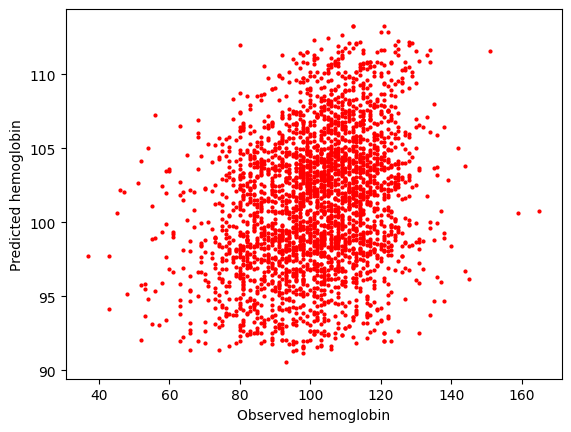

R2 = 0.072


In [120]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def SumSqr(y):
    y_mean=y.mean()
    return ((y-y_mean)**2).sum()

def SumSqrModel(model,X_obs,y_obs):
    return 1 - SumSqr(y_obs-model.predict(X_obs))/SumSqr(y_obs)

def ShowModel(model,X_obs,y_obs,obs_lab='Observed',pred_lab='Predicted'):
    y_pred=model.predict(X_obs)
    plt.plot(y_obs,y_pred,'ro',markersize=2)
    plt.xlabel(obs_lab)
    plt.ylabel(pred_lab)
    plt.show()
    return 1 - SumSqr(y_obs-y_pred)/SumSqr(y_obs)    

X_train, X_test, y_train, y_test = train_test_split(clean_data.drop(columns='childs_hemoglobin'),clean_data['childs_hemoglobin'],test_size=0.3)

# Make some regression model and draw the resulting observed vs predicted relation:
model=Lasso(alpha=0.01).fit(X_train,y_train)
#model=LinearRegression().fit(X_train,y_train)
for i in range(0,len(model.coef_)):
    print('%s: %0.4f' % (model.feature_names_in_[i],model.coef_[i]))
print('R2 = %0.3f' % ShowModel(model,X_test,y_test,obs_lab="Observed hemoglobin",pred_lab="Predicted hemoglobin"))



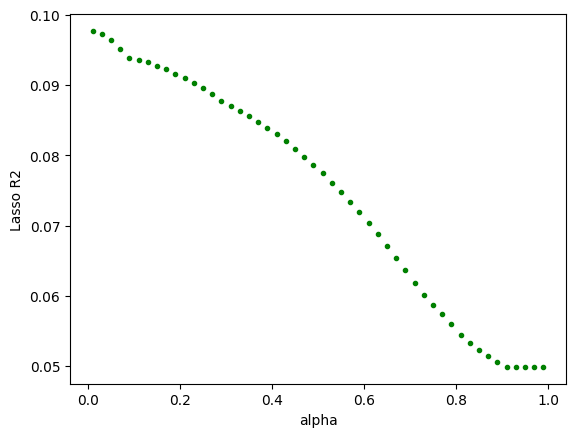

In [117]:
# Lasso's dependence on its alpha:
alphas=numpy.arange(start=0.01,stop=1.00,step=0.02)
r2s=[]
for alpha in alphas:
    r2s.append(SumSqrModel(Lasso(alpha=alpha).fit(X_train,y_train),X_test,y_test))
    
plt.plot(alphas,r2s,'go',markersize=3)
plt.xlabel('alpha')
plt.ylabel('Lasso R2')
plt.show()